# 최종 모델 LinearRegression (v4_Final version에서의 최종)

- 그리드서치CV를 이용한 최적의 하이퍼파라미터로 튜닝
- 이후 각 모델마다 후진제거방법으로 피처 셀렉션

### import

In [1]:
# 모듈 불러오기
import pandas as pd
import numpy as np
import re
import ast

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree

from model import *
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import learning_curve

import statsmodels.api as sm
import warnings
warnings.filterwarnings(action='ignore')
from IPython.display import Image

In [82]:
# 데이터 불러오기
df = pd.read_excel('../data/file/ml_all.xlsx', index_col=0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 601 entries, 0 to 600
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  601 non-null    object 
 1   english_title                 601 non-null    object 
 2   year                          601 non-null    int64  
 3   total_season_num              601 non-null    int64  
 4   runtime                       601 non-null    int64  
 5   genre                         601 non-null    object 
 6   age_rating                    601 non-null    int64  
 7   production_country            601 non-null    object 
 8   PCA                           601 non-null    float64
 9   genre_len                     601 non-null    int64  
 10  production_country_freq_code  601 non-null    int64  
 11  production_country_code       601 non-null    int64  
 12  seson_n                       601 non-null    int64  
 13  i_s1_rate 

In [83]:
# 각 범주(나라)의 타겟 변수(여기서는 runtime의 평균) 계산
country_means = df.groupby('production_country')['PCA'].mean()

# 타겟 인코딩 적용
df['production_country_encoded'] = df['production_country'].map(country_means)

In [84]:
# 넷플릭스 장르 선호도 순위 리스트 (선호도 순서대로 정렬)
genres = [
    '드라마', '코미디', 'SF', '액션', '스릴러', '범죄', '공포', '로맨스', '판타지', '전쟁', '서부', '그 외'
]

# 각 장르에 점수를 선형적으로 할당하여 딕셔너리로 만들기
genre_scores = {genre: 1 - i / (len(genres)) for i, genre in enumerate(genres)}

# '그 외'에 해당되는 장르 리스트
other_genres = ['역사', '가족', '음악', 'Made in Europe', '스포츠']

# 장르 문자열을 받아서 점수를 계산하는 함수

def get_genre_score(genre_str):
    # 장르를 ', '로 분리
    genre_list = genre_str.split(', ')
    
    # '그 외'에 포함된 하위 장르가 있는지 확인
    for genre in genre_list:
        if genre in other_genres:
            return genre_scores['그 외']
    
    # 각 장르의 점수의 평균 계산
    total_score = 0
    count = 0
    for genre in genre_list:
        score = genre_scores.get(genre, genre_scores['그 외'])  # 없는 장르는 '그 외' 점수로 처리
        total_score += score
        count += 1
    
    # 평균 점수 계산
    average_score = total_score / count if count > 0 else 0
    return average_score

# 장르별 점수
df['genre'] = df['genre'].apply(get_genre_score)

In [85]:
# 로그 변환 적용 

df['i_s2_rate_cnt'] = np.log1p(df['i_s2_rate_cnt'])  # log(1+x) 변환 사용
df['w_s2_rate_cnt'] = np.log1p(df['w_s2_rate_cnt'])
df['s2_rate_cnt_retention'] = np.log1p(df['s2_rate_cnt_retention'])
df['s1_gap_days'] = np.log1p(df['s1_gap_days'])
df['age_rating'] = np.log1p(df['age_rating'])
df['season_gaps_days'] = np.log1p(df['season_gaps_days'])
df['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])  # log(1+x) 변환 사용
df['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
df['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

In [86]:
# y값(흥행도)

# 각 요소 계산
rate = (0.8 * df['i_s2_rate']) + (0.2 * df['w_s2_rate'])
cnt = (0.8 * df['i_s2_rate_cnt']) + (0.2 * df['w_s2_rate_cnt'])
ret = (0.4 * df['s2_rate_retention']) + (0.6 * df['s2_rate_cnt_retention'])

# 총 점수 계산
total = (0.3 * rate + 0.5 * cnt + 0.2 * ret) *10

# 점수를 데이터프레임에 추가
df['score'] = total

---

## 1-1. 최종 모델(LinearRegression) 결과

In [87]:
# 후진 제거 피처 셀렉션 함수
def backward_elimination(model, X_train, y_train, X_test, y_test):
    features = X_train.columns.tolist()
    best_mse = mean_squared_error(y_test, model.fit(X_train, y_train).predict(X_test))
    best_features = features.copy()

    while len(best_features) > 0:
        worst_feature = None
        worst_mse = best_mse

        for feature in best_features:
            temp_features = best_features.copy()
            temp_features.remove(feature)

            X_train_temp = X_train[temp_features]
            X_test_temp = X_test[temp_features]
            model.fit(X_train_temp, y_train)
            mse = mean_squared_error(y_test, model.predict(X_test_temp))

            if mse < worst_mse:
                worst_mse = mse
                worst_feature = feature

        if worst_feature is not None:
            best_features.remove(worst_feature)
            best_mse = worst_mse
        else:
            break

    print(f"Selected Features: {best_features}")
    print("=" * 40)
    return best_mse, best_features

In [88]:
df_1 = df[['runtime','genre','age_rating','production_country_encoded','PCA','genre_len','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_retention','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days','score']]

In [89]:
X = df_1.drop(['score'], axis=1)  # 'score' 열을 제외한 모든 열 선택
y = df_1['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

In [90]:
# LinearRegression 모델에 대해 후진 제거 피처 셀렉션 수행
best_mse_lr, best_features_lr = backward_elimination(LinearRegression(), X_train, y_train, X_test, y_test)

# 선택된 특성들로 LinearRegression 모델 학습 및 평가
X_train_selected_lr = X_train[best_features_lr]
X_test_selected_lr = X_test[best_features_lr]

lr_model = LinearRegression()
lr_model.fit(X_train_selected_lr, y_train)
y_pred_lr = lr_model.predict(X_test_selected_lr)

lr_mse = mean_squared_error(y_test, y_pred_lr)
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_r2 = r2_score(y_test, y_pred_lr)

print("LinearRegression 모델 성능 평가:")
print(f"MSE: {lr_mse}")
print(f"MAE: {lr_mae}")
print(f"R^2: {lr_r2}")
print(f"Selected Features: {best_features_lr}")

Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']
LinearRegression 모델 성능 평가:
MSE: 2.7881908681324785
MAE: 1.3026580418006124
R^2: 0.9678141317560938
Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']


## 2. 최종 모델(LinearRegression) 그래프

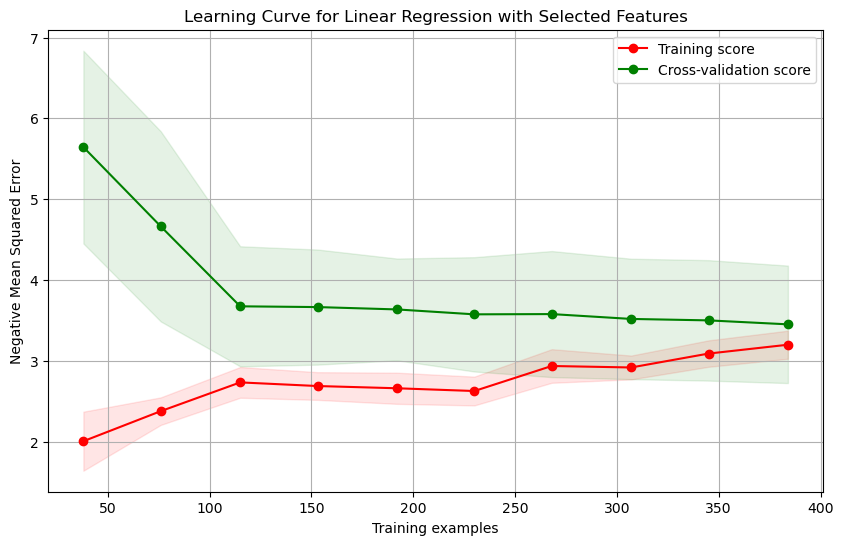

In [91]:
# learning curve 계산
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
    lr_model, X_train_selected_lr, y_train, cv=5, scoring='neg_mean_squared_error', 
    train_sizes=np.linspace(0.1, 1.0, 10), return_times=True
)

# 성능 지표 계산
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# 학습 곡선 그리기
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel('Training examples')
plt.ylabel('Negative Mean Squared Error')
plt.title('Learning Curve for Linear Regression with Selected Features')
plt.legend(loc="best")
plt.grid()
plt.show()

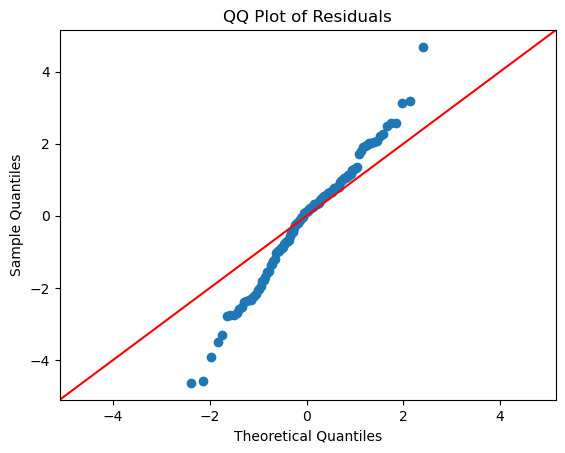

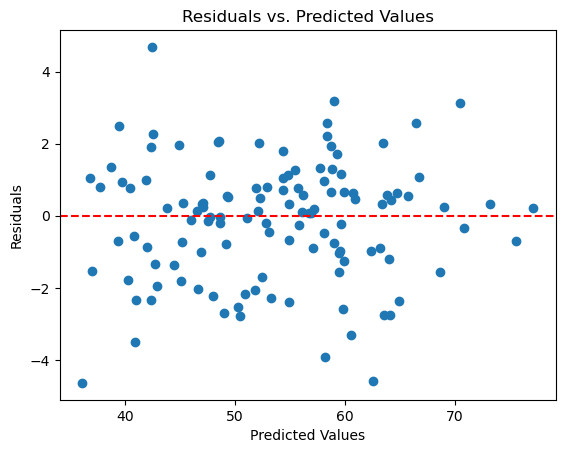

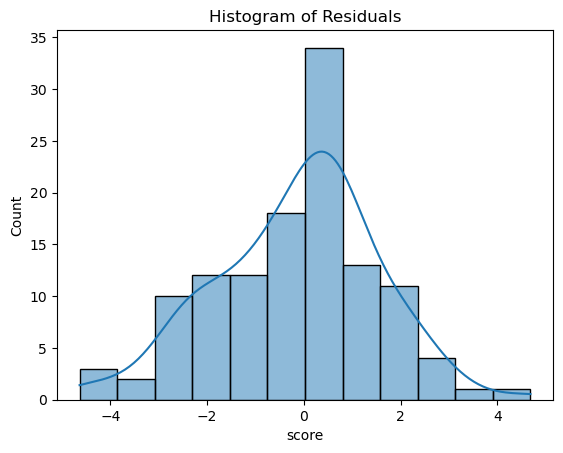

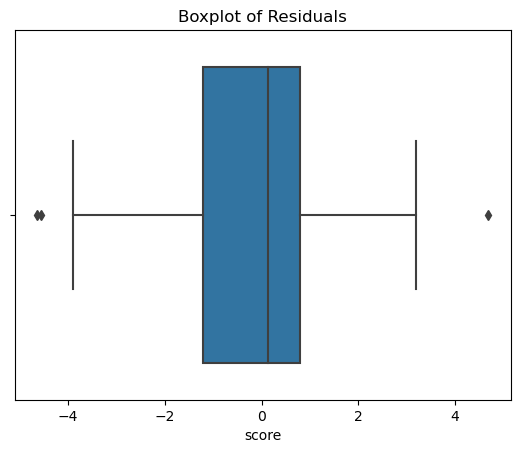

In [92]:
# 예측값 계산
y_pred = lr_model.predict(X_test_selected_lr)

# 잔차 계산
residuals = y_test - y_pred

# QQ 차트 생성
sm.qqplot(residuals, line ='45')
plt.title('QQ Plot of Residuals')
plt.show()

# 잔차 vs. 예측값 플롯
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# 잔차 히스토그램
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# 잔차 박스 플롯
sns.boxplot(x=residuals)
plt.title('Boxplot of Residuals')
plt.show()

## 3. 실제와 예측값 비교

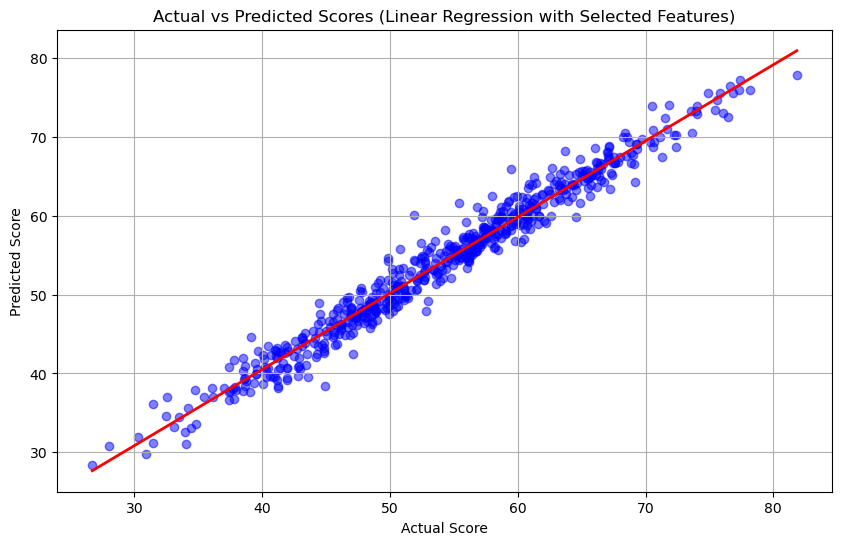

In [93]:
# 예측값 계산
y_train_pred = lr_model.predict(X_train_selected_lr)
y_test_pred = lr_model.predict(X_test_selected_lr)

# 훈련 데이터와 테스트 데이터를 합친 전체 데이터셋
X_combined = np.vstack((X_train_selected_lr, X_test_selected_lr))
y_combined = np.concatenate((y_train, y_test))
y_combined_pred = np.concatenate((y_train_pred, y_test_pred))

# 산점도 그리기
plt.figure(figsize=(10, 6))
plt.scatter(y_combined, y_combined_pred, color='blue', alpha=0.5)
plt.xlabel('Actual Score')
plt.ylabel('Predicted Score')
plt.title('Actual vs Predicted Scores (Linear Regression with Selected Features)')
plt.grid(True)

# 회귀선 그리기
# y = mx + c 형태의 직선의 기울기(m)와 절편(c)을 계산합니다.
m, c = np.polyfit(y_combined, y_combined_pred, 1)
x_range = np.linspace(min(y_combined), max(y_combined), 100)
y_range_pred = m * x_range + c
plt.plot(x_range, y_range_pred, color='red', linewidth=2)

plt.show()

In [94]:
# 예측 결과와 실제 결과를 비교
comparison_df = pd.DataFrame({
        'korean_title': df['korean_title'],
        'season_num':df['seson_n'],
        'actual': df['score'],
        'predicted': y_combined_pred,
        'diff': df['score'] - y_combined_pred
    })

In [95]:
comparison_df.head(10)

,korean_title,season_num,actual,predicted,diff
0,스위트 투스: 사슴뿔을 가진 소년,2,54.275917,60.901189,-6.625272
1,스위트홈,2,50.797603,67.363328,-16.565725
2,굿 닥터,2,62.998841,41.851111,21.147730
3,워킹 데드,2,74.914486,50.216985,24.697501
4,"비르기트: 왕국, 권력, 영광",2,52.085723,56.245361,-4.159638
5,플래시,2,67.034694,53.751443,13.283250
6,브리저튼,2,63.257575,42.279738,20.977837
7,슈츠,2,66.291155,37.031587,29.259569
8,다크,2,72.397240,52.514267,19.882973
9,아웃랜더,2,65.399103,56.197476,9.201627


In [96]:
# 후속작 예상 점수 상위 20개
comparison_df.sort_values('predicted', ascending=False).head(20)

,korean_title,season_num,actual,predicted,diff
348,나르코스: 멕시코,3,57.637184,77.783632,-20.146448
539,피키 블라인더스,6,68.475545,77.160697,-8.685152
461,그레이스 앤 프랭키,4,56.618532,76.385699,-19.767167
13,바이킹스,2,67.593360,75.951074,-8.357714
286,리전,3,59.431642,75.890431,-16.458789
526,반 헬싱,5,43.959264,75.600855,-31.641590
202,더 기프트,2,46.666904,75.573691,-28.906786
82,블러드라인,2,55.220006,75.562007,-20.342001
241,A 리스트,2,41.231596,74.719119,-33.487523
396,안녕 여름,3,34.697552,74.015226,-39.317675


## 4. 흥행 등급 부여

In [97]:
# 흥행 등급 부여
comparison_df['rank'] = pd.qcut((comparison_df['predicted'].rank(pct=True)), q=[0, 0.3, 0.7, 0.95, 1], labels=['부진', '호불호', '흥행', '대흥행'])

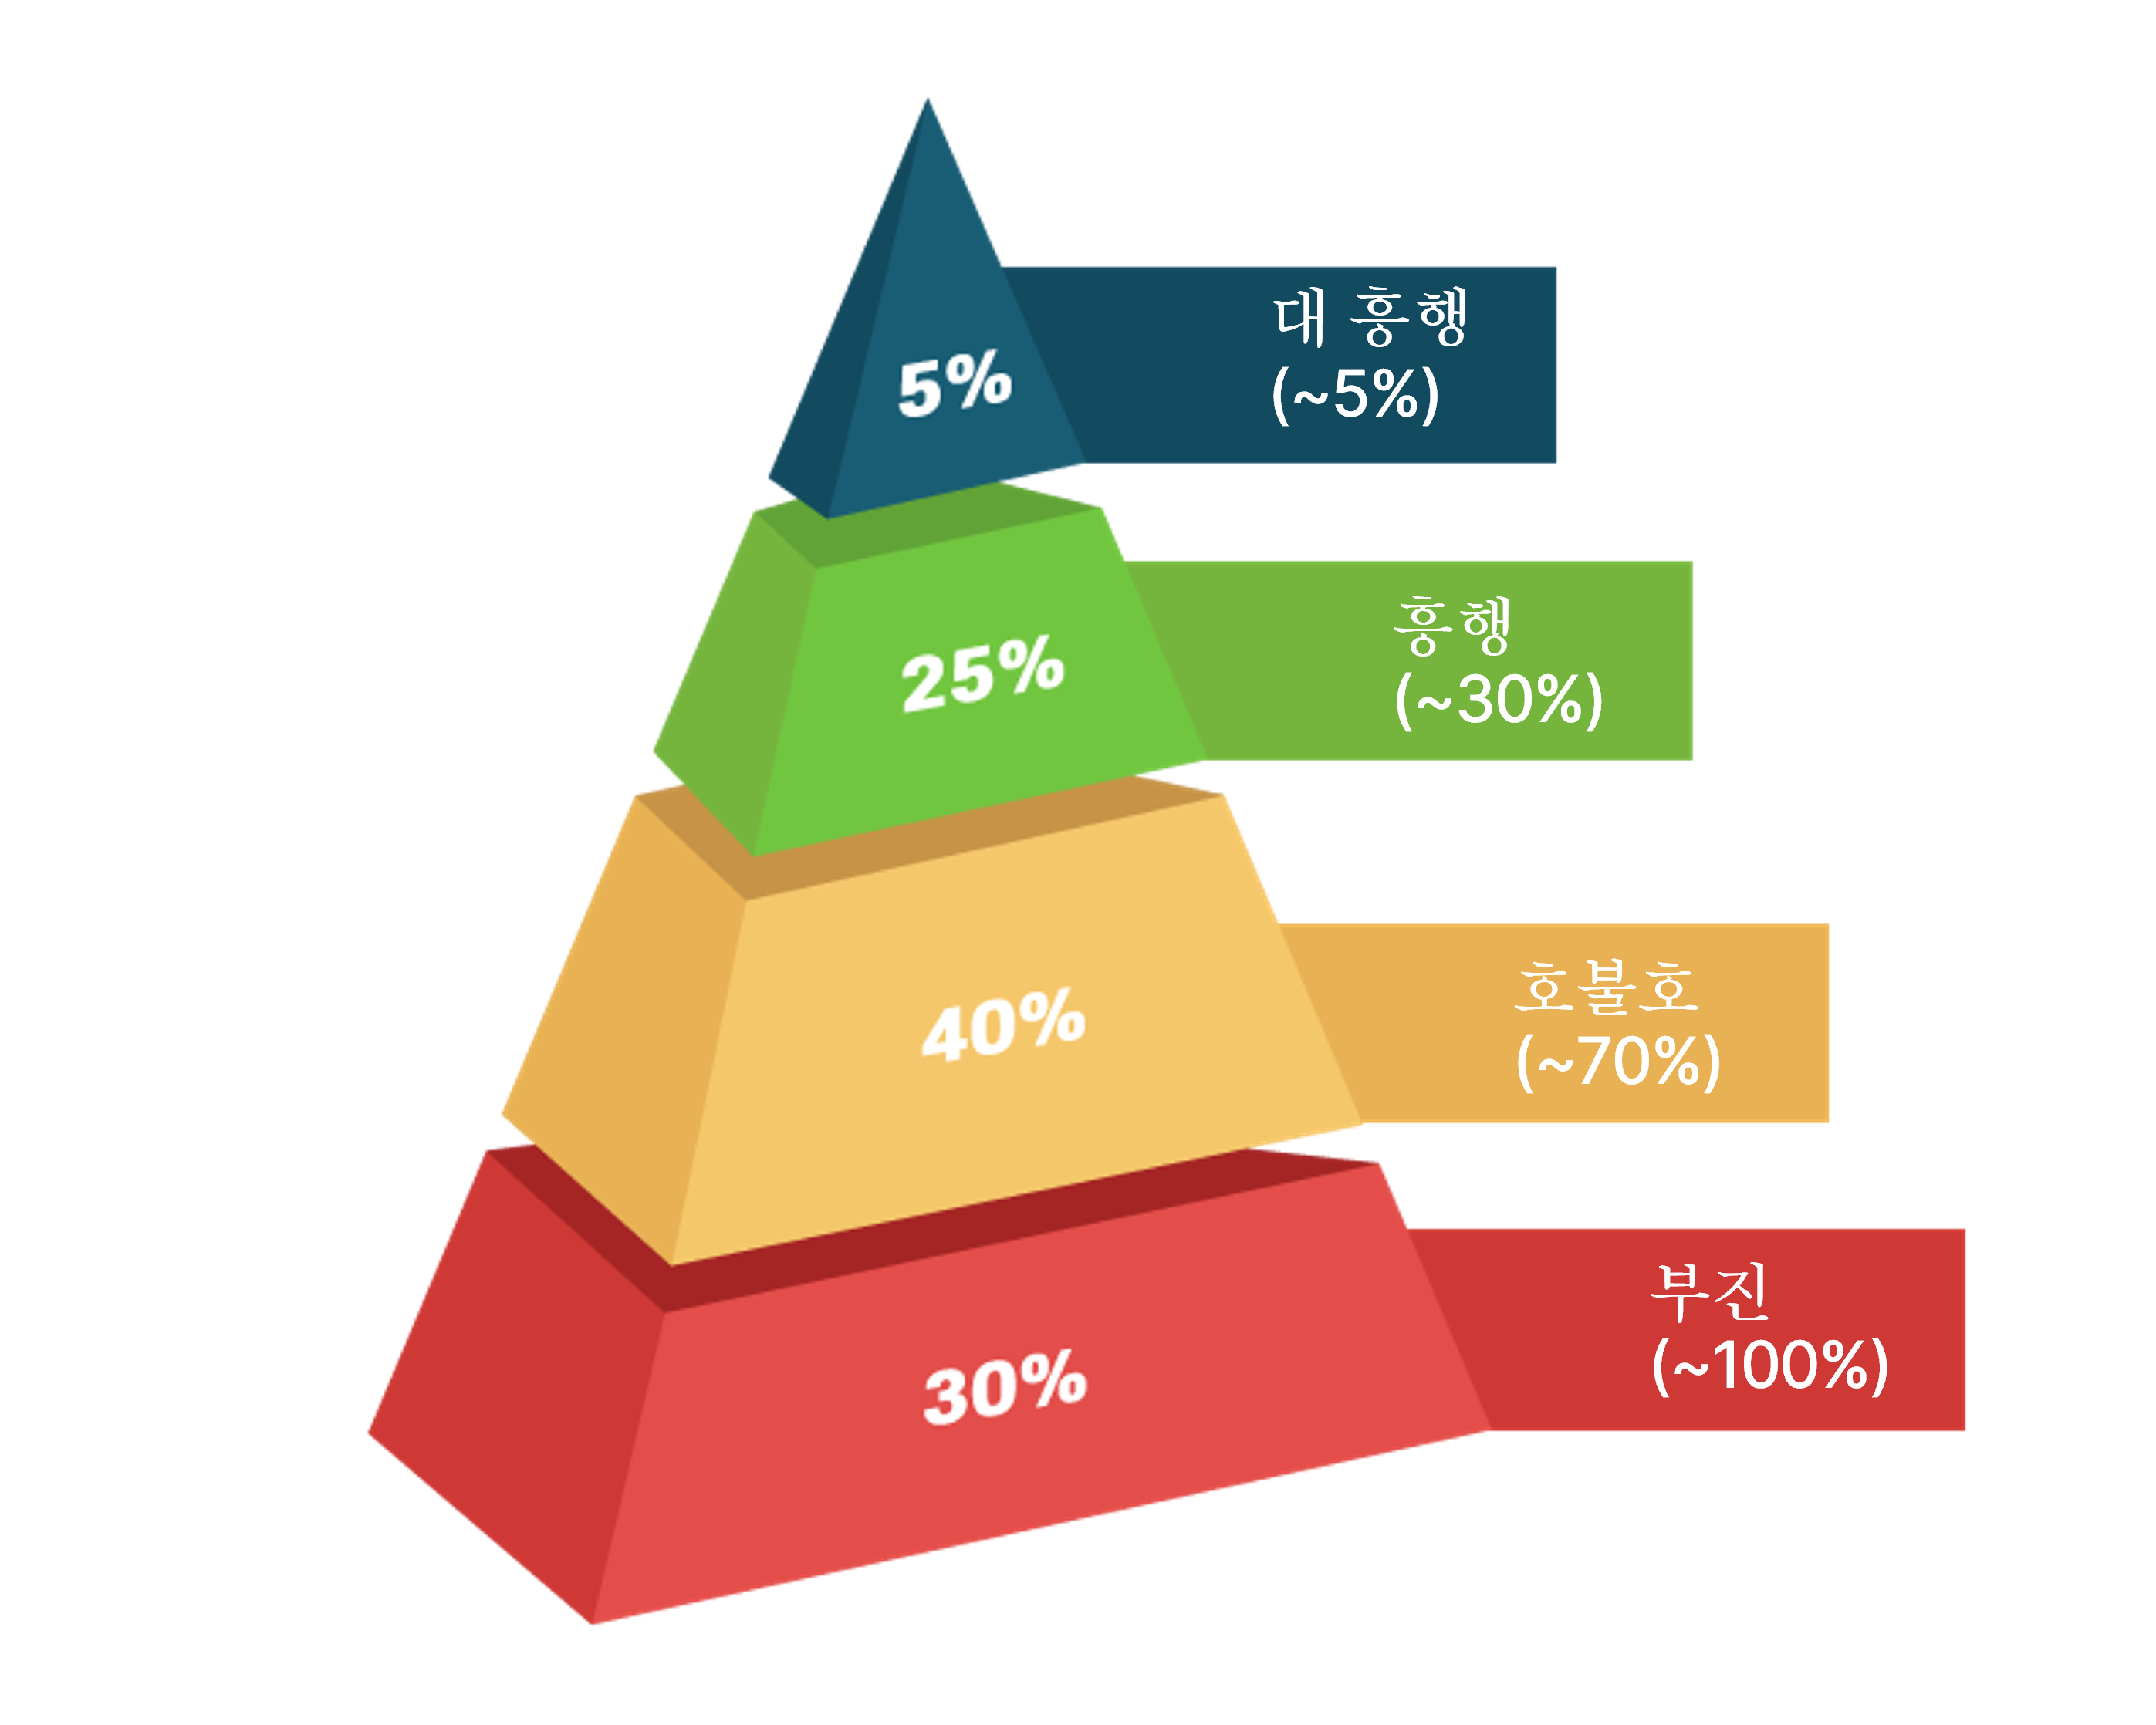

In [2]:
Image(filename='../data/image/result_1.png')

In [98]:
# 흥행 등급 부여
comparison_df['real_rank'] = pd.qcut((comparison_df['actual'].rank(pct=True)), q=[0, 0.3, 0.7, 0.95, 1], labels=['부진', '호불호', '흥행', '대흥행'])

In [99]:
# 흥행 등급 예시
comparison_df[['korean_title', 'season_num', 'predicted', 'rank','real_rank']].head(10)

,korean_title,season_num,predicted,rank,real_rank
0,스위트 투스: 사슴뿔을 가진 소년,2,60.901189,흥행,호불호
1,스위트홈,2,67.363328,흥행,호불호
2,굿 닥터,2,41.851111,부진,흥행
3,워킹 데드,2,50.216985,호불호,대흥행
4,"비르기트: 왕국, 권력, 영광",2,56.245361,호불호,호불호
5,플래시,2,53.751443,호불호,흥행
6,브리저튼,2,42.279738,부진,흥행
7,슈츠,2,37.031587,부진,흥행
8,다크,2,52.514267,호불호,대흥행
9,아웃랜더,2,56.197476,호불호,흥행


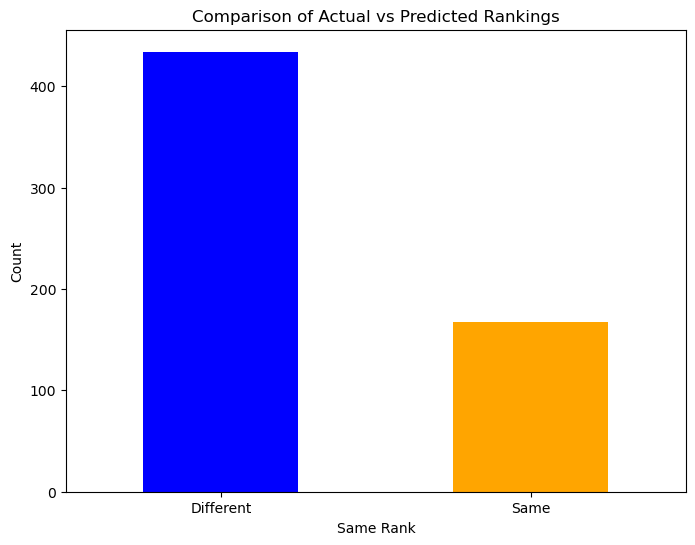

In [100]:
# 예측 등급과 실제 등급이 같은지 여부를 나타내는 컬럼 생성
comparison_df['same_rank'] = comparison_df['rank'] == comparison_df['real_rank']

# 동일한 등급과 다른 등급의 개수 계산
comparison_counts = comparison_df['same_rank'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(8, 6))
comparison_counts.plot(kind='bar', color=['blue', 'orange'], rot=0)
plt.title('Comparison of Actual vs Predicted Rankings')
plt.xlabel('Same Rank')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Different', 'Same'])
plt.show()

----

## 5. 오징어게임2 예상

In [101]:
# 데이터 불러오기
s1 = pd.read_excel('../data/file/ml_s1.xlsx', index_col=0)

s1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 0 to 638
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   korean_title                  639 non-null    object 
 1   english_title                 639 non-null    object 
 2   year                          639 non-null    int64  
 3   total_season_num              639 non-null    int64  
 4   runtime                       639 non-null    int64  
 5   genre                         639 non-null    object 
 6   age_rating                    639 non-null    int64  
 7   production_country            639 non-null    object 
 8   PCA                           639 non-null    float64
 9   genre_len                     639 non-null    int64  
 10  production_country_freq_code  639 non-null    int64  
 11  production_country_code       639 non-null    int64  
 12  i_s1_rate                     639 non-null    float64
 13  i_s1_rate_

In [102]:
target = s1[s1['english_title']=='Squid Game']

target

,korean_title,english_title,year,total_season_num,runtime,genre,age_rating,production_country,PCA,genre_len,production_country_freq_code,production_country_code,i_s1_rate,i_s1_rate_cnt,w_s1_rate,w_s1_rate_cnt,s1_rate_retention,s1_rate_cnt_retention,s1_gap_days
0,오징어 게임,Squid Game,2021,1,55,"액션, 드라마, 스릴러",19,대한민국,4.052857,3,160,0,8.011111,14888.888889,3.3,95000,0.914634,0.875,0


In [103]:
# 장르별 점수
target['genre'] = target['genre'].apply(get_genre_score)

# season_gaps_days
target['season_gaps_days'] = 1183                                                #'Fri, Dec 13, 2024'(시즌2 에피소드 처음 일자)  - 'Fri, Sep 17, 2021'(시즌1 에피소드 마지막 일자) 

# 제작국가 
target['production_country_encoded'] = -0.361577

# seson_n
target['seson_n'] = target['total_season_num']

# 로그 변환 적용 
target['s1_gap_days'] = np.log1p(df['s1_gap_days'])
target['age_rating'] = np.log1p(df['age_rating'])
target['season_gaps_days'] = np.log1p(df['season_gaps_days'])
target['i_s1_rate_cnt'] = np.log1p(df['i_s1_rate_cnt'])  # log(1+x) 변환 사용
target['w_s1_rate_cnt'] = np.log1p(df['w_s1_rate_cnt'])
target['s1_rate_cnt_retention'] = np.log1p(df['s1_rate_cnt_retention'])

C:\Users\rbfl7\AppData\Local\Temp\ipykernel_24504\230298423.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['genre'] = target['genre'].apply(get_genre_score)
C:\Users\rbfl7\AppData\Local\Temp\ipykernel_24504\230298423.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target['season_gaps_days'] = 1183                                                #'Fri, Dec 13, 2024'(시즌2 에피소드 처음 일자)  - 'Fri, Sep 17, 2021'(시즌1 에피소드 마지막 일자)
C:\Users\rbfl7\AppData\Local\Temp\ipykernel_24504\230298423.py:8: Setting

Selected Features: ['runtime', 'genre', 'age_rating', 'production_country_encoded', 'seson_n', 'i_s1_rate', 'i_s1_rate_cnt', 's1_rate_cnt_retention', 'w_s1_rate', 'w_s1_rate_cnt', 's1_gap_days', 'season_gaps_days']

In [104]:
squid_game2_df = target[['runtime','genre','age_rating','production_country_encoded','seson_n','i_s1_rate','i_s1_rate_cnt','s1_rate_cnt_retention','w_s1_rate','w_s1_rate_cnt','s1_gap_days','season_gaps_days']]

In [105]:
squid_game2_pred = lr_model.predict(squid_game2_df)
average_actual = comparison_df['actual'].mean()
average_predicted = comparison_df['predicted'].mean()

In [106]:
squid_game2_pred

array([31.74406805])

In [107]:
print(f"오징어게임2의 예상 흥행 점수: {squid_game2_pred[0]}")
print(f"평균 실제 흥행 점수: {average_actual}")
print(f"평균 예측 흥행 점수: {average_predicted}")

# 오징어게임2 점수 비교
if squid_game2_pred[0] > average_predicted:
    print("오징어게임2의 예상 흥행 점수는 평균보다 높습니다.")
else:
    print("오징어게임2의 예상 흥행 점수는 평균보다 낮습니다.")

오징어게임2의 예상 흥행 점수: 31.744068051648583
평균 실제 흥행 점수: 54.07296072400102
평균 예측 흥행 점수: 54.10116502230015
오징어게임2의 예상 흥행 점수는 평균보다 낮습니다.


---